In [16]:
import numpy as np

from scipy.optimize import minimize_scalar, newton, fsolve
from scipy.integrate import quad
import scipy.signal as sig
from scipy.special import erf, spherical_jn
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

First compare the case of massless mediator in the point charge limit with exact formula and numerical integration

In [17]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1
N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

#q_thr = 0.05e9    # momentum threshold, eV
q_thr = 0

In [18]:
M_X = 5e3 * 1e9
alpha = 1e-8 * N_T

vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity

In [19]:
v = 0.5 * (vmin + vesc)

p = M_X * v            # DM initial momentum (eV)
E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle
pmax = np.max((vesc * M_X, 10e9))

b_um = np.logspace(-3, 5, 2000)
b = b_um / hbarc       # Impact factor (eV^-1)

In [20]:
def vtot(u, m_phi, alpha, point_charge=False):
    mR = m_phi * R
    
    u = np.asarray(u)
    ret = np.empty_like(u)
    
    if point_charge:
        if (mR > 0):
            ret = alpha * u * np.exp(-1 * m_phi / u)
        else:
            ret = alpha * u
        return ret
    
    # Divide the array of u=1/r into three cases
    neg     = (u <= 0)   # ill-defined
    outside = (u < 1/R)  # ouside sphere
    inside  = (u >= 1/R) # inside sphere
    
    ret[neg] = np.inf
    
    if(mR > 0):   # massive mediator
        ret[outside] = 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u[outside]) * u[outside]
        ret[inside] = 3 * alpha/mR**3 * (m_phi - u[inside]*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u[inside])/np.sinh(mR)))
        
    else:         # massless mediator (alpha/r)
        ret[outside] = alpha * u[outside]
        ret[inside] = alpha/2 * (3/R - 1./(R**3 * u[inside]**2))

    return ret

In [30]:
def integrand_old(u, E, _b, m_phi, alpha, point_charge):
    sval = 1 - vtot(u, m_phi, alpha, point_charge) / E - (_b*u)**2
    if sval < 1e-10:  # cut off bad values that should be zero
        sval= np.inf

    integ = _b / np.sqrt(sval)
    return integ

In [31]:
def b_theta_old(M_X, m_phi, alpha, v, point_charge=False):
    p = M_X * v            # DM initial momentum (eV)
    E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle

    # Make a list of impact parameters
    if(m_phi > 0):
        b_um = np.logspace(-5, 3, 2000)
    else:
        b_um = np.logspace(-5, 5, 2000)
    b = b_um / hbarc       # Impact factor (eV^-1)

    # Calculate scattering angle `theta` for each element in `b`
    max_u = max_u_numerical(E, b, m_phi, alpha, point_charge)
    Psi = np.empty_like(b)
    for i, _b in enumerate(b):
        umax = max_u[i]
        _b = b[i]
        Psi[i] = quad(integrand_old, 0, umax, args=(E, _b, m_phi, alpha, point_charge))[0]

    theta = np.pi - 2 * Psi

    good_pts = np.logical_not( np.logical_or(np.isnan(theta), np.isinf(theta)) )
    theta = theta[good_pts]
    b = b[good_pts]

    return p, b, theta

In [23]:
def max_u_func(u, E, b, m_phi, alpha, point_charge):
    return np.log(np.abs(1 - (b*u)**2 - vtot(u, m_phi, alpha, point_charge) / E))

def max_u_numerical(E, b, m_phi, alpha, point_charge):    
    # Zero of the function closest to each `b`
    ## Old implementations both give bad result
#     max_u = newton(max_u_func, x0=1/b, args=(b, E, m_phi, alpha, point_charge))
#     max_u = minimize_scalar(max_u_func, args=(E, b, m_phi, alpha, point_charge), bounds=(hbarc/1e3,hbarc/1e-3),method='bounded',options={'disp': 0, 'xatol': 1e-15})
#     return max_u.x

    if not hasattr(b, '__iter__'):
        b = np.asarray([b])
        
    # Iteratively find the min value of the function
    max_u = np.empty_like(b)
    if point_charge:
        ulower, uupper = -8, 6
    else:
        ulower, uupper = -8, 8
    
    # Max u for each b
    for i, bb in enumerate(b):
        uu = np.logspace(ulower, uupper, 10000)
        count = 0
        converge = False
        
        while (not converge):
            ff = max_u_func(uu, E, bb, m_phi, alpha, point_charge)
            min_arg = np.argmin(ff)
            if ( ff[min_arg] < -15 ): # Func value smaller than exp(-15)
                converge = True
                max_u[i] = uu[min_arg]
            
            else:
                # Usually it converges very quickly (only 1 or 2 iterations are needed)
                if (count > 100):
                    print('Fail to converge after 100 iterations')
                    max_u[i] = uu[min_arg]
                    break

                elif (min_arg == 0 or min_arg == 9999):
                    print('Need to increase lower/upper limit')
                    max_u[i] = uu[min_arg]
                    break
                    
                else:
                    count += 1                
                    uu = np.linspace(uu[min_arg-1], uu[min_arg+1], 10000)
    return max_u

In [24]:
b_um = np.logspace(-5, 5, 2000)
b = b_um / hbarc

Text(0, 0.5, 'Minimum r')

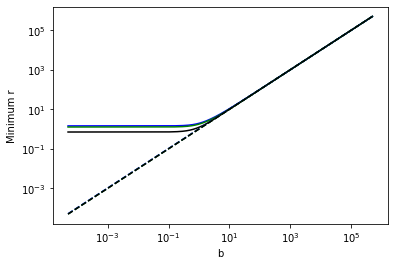

In [25]:
plt.plot(b, 1/max_u_numerical(E, b, 0, alpha, point_charge=True), 'b', label='$m_phi = 0$, PC')
plt.plot(b, 1/max_u_numerical(E, b, 0.1, alpha, point_charge=True), 'g', label='$m_phi = 0.1$, PC')
plt.plot(b, 1/max_u_numerical(E, b, 1, alpha, point_charge=True), 'k', label='$m_phi = 1$, PC')

plt.plot(b, 1/max_u_numerical(E, b, 0, alpha, point_charge=False), 'b--', label='$m_phi = 0$, Extended')
plt.plot(b, 1/max_u_numerical(E, b, 0.1, alpha, point_charge=False), 'g--', label='$m_phi = 0.1, Extended')
plt.plot(b, 1/max_u_numerical(E, b, 1, alpha, point_charge=False), 'k--', label='$m_phi = 1$, Extended')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('b')
plt.ylabel('Minimum r')

In [26]:
def integrand(rho, umax, E, b, m_phi, alpha, point_charge):
    rmin = 1 / umax
    
    r = rmin / (1 - rho * rho)
    first_term = (rmin*rmin / (rho*rho*E)) * (vtot(umax, m_phi, alpha, point_charge) - vtot(1/r, m_phi, alpha, point_charge))
    second_term = b * b * (2 - rho*rho)
    
    return 1 / np.sqrt(first_term + second_term)

In [27]:
def b_theta(M_X, m_phi, alpha, v, point_charge):
    p = M_X * v            # DM initial momentum (eV)
    E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle

    # Make a list of impact parameters
    # Impact factor `b` (eV^-1)
    if(m_phi > 0):
        b_um = np.logspace(-5, 5, 2000)
    else:
        b_um = np.logspace(-5, 5, 2000)
    b = b_um / hbarc
    
    umax = max_u_numerical(E, b, m_phi, alpha, point_charge)
    Psi = np.empty_like(b)
    for i, _b in enumerate(b):
        Psi[i] = quad(integrand, 0, 1, args=(umax[i], E, _b, m_phi, alpha, point_charge))[0]
        
    theta = np.pi - 4 * b * Psi
    
    return p, b, theta

In [28]:
p, b, theta = b_theta(M_X, 0.1, alpha, v, False)

In [32]:
p_o, b_o, theta_o = b_theta_old(M_X, 0.1, alpha, v, False)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_13088\3476830336.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Psi[i] = quad(integrand_old, 0, umax, args=(E, _b, m_phi, alpha, point_charge))[0]
C:\Users\yuhan\AppData\Local\Temp\ipykernel_13088\3476830336.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Psi[i] = quad(integrand_old, 0, umax, args=(E, _b, m_ph

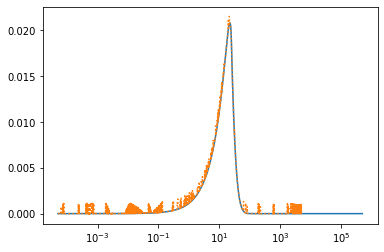

In [33]:
plt.plot(b, theta)
plt.plot(b_o, theta_o, ':')
plt.xscale('log')

In [34]:
def dsig_dq(p, pmax, b, theta):
    bcidx = np.argmax(theta)
    bcrit = b[bcidx]

    ## now need the cross section above and below bcrit
    b1, t1 = b[:bcidx], theta[:bcidx]
    b2, t2 = b[bcidx:], theta[bcidx:]

    q1 = p * np.sqrt( 2*(1-np.cos(t1)) )
    q2 = p * np.sqrt( 2*(1-np.cos(t2)) )
    q = p * np.sqrt( 2*(1-np.cos(theta)) )

    q_lin = np.linspace(1e-8, 2*pmax*1.1, 10000)
    if(len(b1) > 1 ):
        q1_sorted, q1_idx = np.unique(q1, return_index=True)
        b1_cubic = CubicSpline(q1[q1_idx], b1[q1_idx])(q1[q1_idx])
        db1 = np.abs(np.gradient(b1_cubic, q1[q1_idx]))
        
    q2_sorted, q2_idx = np.unique(q2, return_index=True)
    b2_cubic = CubicSpline(q2[q2_idx], b2[q2_idx])(q2[q2_idx])
    db2 = np.abs(np.gradient(b2_cubic, q2[q2_idx]))
    
    if (len(b1) > 1 ):
        dsigdq1 = np.interp(q_lin, q1[q1_idx], 2 * np.pi * b1[q1_idx] * db1, right=0)
    else:
        dsigdq1 = np.zeros_like(q_lin)
    dsigdq2 = np.interp(q_lin, q2[q2_idx], 2 * np.pi * b2[q2_idx] * db2, right=0)

    dsigdq_tot = dsigdq1 + dsigdq2
    dsigdq_tot[q_lin < q_thr] = 0  # Cut off at the momentum threshold
    
    return q_lin, dsigdq_tot

In [35]:
def dsig_domega_born(mx, mphi, alpha, q, point_charge=False):
    point_charge_sol = (4 * (mx**2) * (alpha**2) ) / ( (mphi**2 + q**2)**2 )
    if point_charge:
        return point_charge_sol
    else:
        form_factor = 3 * spherical_jn(n=1, z=q*R) / (q * R)
        return point_charge_sol * form_factor**2

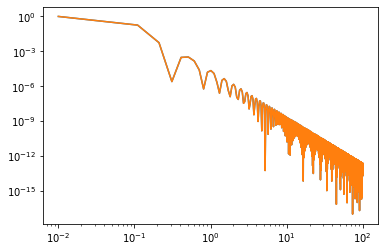

In [36]:
qq = np.linspace(1e-2, 1e2, 1000)
fq = 3 * (np.sin(qq*R) - qq * R * np.cos(qq*R)) / ((qq*R)**3)
fq2 = 3 * spherical_jn(n=1, z=qq*R) / (qq * R)

plt.loglog(qq, fq**2)
plt.loglog(qq, fq2**2)

Massless mediator in the point charge limit (assume no momentum threshold cutoff)

In [37]:
p, b, theta = b_theta(M_X, 0, alpha, v, point_charge=True)

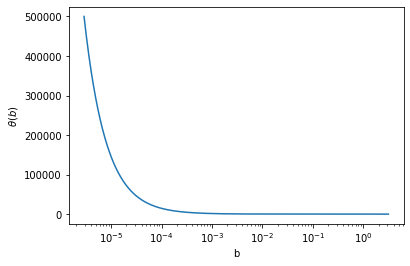

In [51]:
# Will hit numerical issues if use a higher upper limit for b, 
# it seems like the numerical integration fails to converge
# so this step underestimates the low energy tail in the spectrum
plt.plot(theta, b)
plt.xlabel('b')
plt.ylabel(r'$\theta(b)$')
plt.xscale('log')

In [45]:
q, dsigdq_0_pc = dsig_dq(p, pmax, b, theta)

In [59]:
pmax

10000000000.0

Cross section from the Born approximation (it turns out to be the exact solution for massless mediator)

In [46]:
dsdo_born_0_pc = dsig_domega_born(M_X, 0, alpha, q, point_charge=True)
dsdq_born_0_pc = dsdo_born_0_pc * 2 * np.pi * q / (p**2)

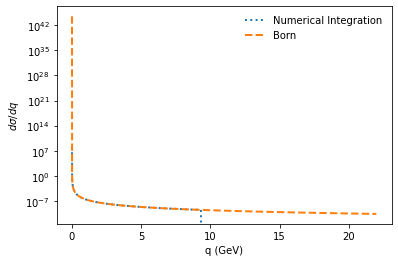

In [54]:
plt.plot(q/1e9, dsigdq_0_pc, ':', linewidth=2, label='Numerical Integration')
plt.plot(q/1e9, dsdq_born_0_pc, '--', linewidth=2, label='Born')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('q (GeV)')
plt.ylabel('$d \sigma /d q$')
plt.legend(frameon=False)

Study the massive mediator case:

In [10]:
mphi = 0.1
p, b, theta = b_theta(M_X, mphi, alpha, v, point_charge=True)

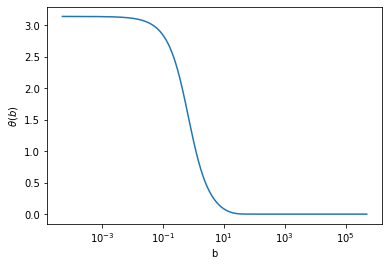

In [11]:
plt.plot(b, theta)
plt.xlabel('b')
plt.ylabel(r'$\theta(b)$')
plt.xscale('log')

In [153]:
q, dsigdq_01_pc = dsig_dq(p, pmax, b, theta)

In [154]:
dsdo_born_01_pc = dsig_domega_born(M_X, mphi, alpha, q, point_charge=True)
dsdq_born_01_pc = dsdo_born_01_pc * 2 * np.pi * q / (p**2)

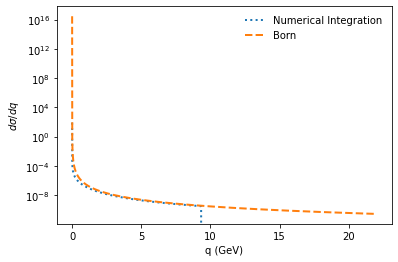

In [155]:
plt.plot(q/1e9, dsigdq_01_pc, ':', linewidth=2, label='Numerical Integration')
plt.plot(q/1e9, dsdq_born_01_pc, '--', linewidth=2, label='Born')
plt.yscale('log')
plt.xlabel('q (GeV)')
plt.ylabel('$d \sigma /d q$')
plt.legend(frameon=False)

Now try massless mediator, finite radius sphere

In [166]:
p, b, theta = b_theta(M_X, 0, alpha, v, point_charge=False)

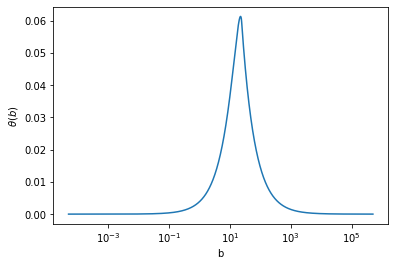

In [168]:
plt.plot(b, theta)
plt.xlabel('b')
plt.ylabel(r'$\theta(b)$')
# plt.yscale('log')
plt.xscale('log')

In [169]:
q, dsigdq_0_finite = dsig_dq(p, pmax, b, theta)

In [170]:
dsdo_born_0_finite = dsig_domega_born(M_X, 0, alpha, q, point_charge=False)
dsdq_born_0_finite = dsdo_born_0_finite * 2 * np.pi * q / (p**2)

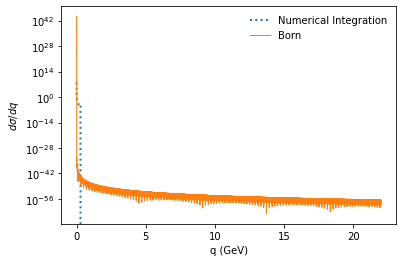

In [171]:
plt.plot(q/1e9, dsigdq_0_finite, ':', linewidth=2, label='Numerical Integration')
plt.plot(q/1e9, dsdq_born_0_finite, '-', linewidth=1, label='Born')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('q (GeV)')
plt.ylabel('$d \sigma /d q$')
plt.legend(frameon=False)

Massive mediator, finite sphere

In [172]:
mphi = 0.1
p, b, theta = b_theta(M_X, mphi, alpha, v, point_charge=False)

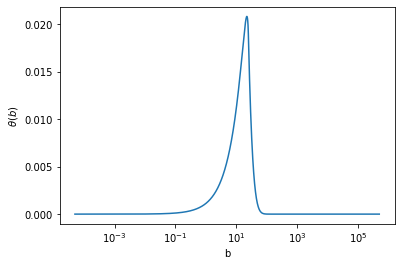

In [174]:
plt.plot(b, theta)
plt.xlabel('b')
plt.ylabel(r'$\theta(b)$')
plt.xscale('log')

In [175]:
q, dsigdq_01_finite = dsig_dq(p, pmax, b, theta)

In [176]:
dsdo_born_01_finite = dsig_domega_born(M_X, mphi, alpha, q, point_charge=False)
dsdq_born_01_finite = dsdo_born_01_finite * 2 * np.pi * q / (p**2)

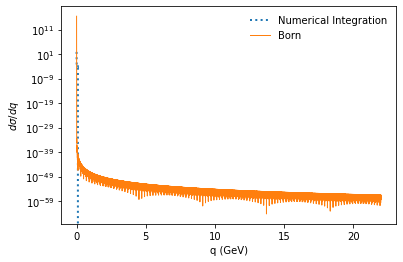

In [177]:
plt.plot(q/1e9, dsigdq_01_finite, ':', linewidth=2, label='Numerical Integration')
plt.plot(q/1e9, dsdq_born_01_finite, '-', linewidth=1, label='Born')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('q (GeV)')
plt.ylabel('$d \sigma /d q$')
plt.legend(frameon=False)